In [1]:
from typing import Dict, List
import matplotlib.pyplot as plt
import networkx as nx
import overpy
import numpy as np
from operator import itemgetter

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from scripts.config import Config

In [4]:
def eval_way(way, config: Config = Config()):
    score = 0
    max_score = config.weight_sum()
    for tag, value in way.tags.items():
        weight, mapping = config[tag]
        score += weight * mapping.get(value, 0)
    return score / max_score

In [5]:
def filter_ways(result, threshold):
    ways = []
    for way in result.ways:
        score = eval_way(way)
        if score > threshold:
            ways.append(way)
    return ways

In [6]:
def ways_to_edges(ways: List[overpy.Way]):
    link_counter: Dict[str, int] = {}
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        for node in nodes:
            link_counter[node.id] = link_counter.get(node.id, 0) + 1

    edges = []
    all_nodes = set()
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        if len(nodes) == 2:
            edges.append([nodes[0].id, nodes[1].id])  # add way as an edge
            all_nodes.add(nodes[0])
            all_nodes.add(nodes[1])
            continue
        head = nodes[0]
        tail = nodes[len(nodes) - 1]
        prev = head
        for i in range(1, len(nodes) - 1):
            node = nodes[i]
            if link_counter[node.id] > 1:
                # break the way on node
                edges.append([prev.id, node.id])
                all_nodes.add(prev)
                all_nodes.add(node)
                prev = node
                if i == len(nodes) - 2:
                    edges.append([node.id, tail.id])
                    all_nodes.add(tail)
    return edges, list(all_nodes)

In [7]:
api = overpy.Overpass()
# result = api.query("nwr(56.3284, -2.8350, 56.3437, -2.7855); out;")  # st andrews
result = api.query("nwr(56.3375, -2.8059, 56.3422, -2.7888); out;")

In [8]:
ways = filter_ways(result, 0)

In [9]:
edges, all_nodes = ways_to_edges(ways)

In [10]:
layout = {node.id: (float(node.lon), float(node.lat)) for node in all_nodes}

In [11]:
G = nx.Graph(edges)

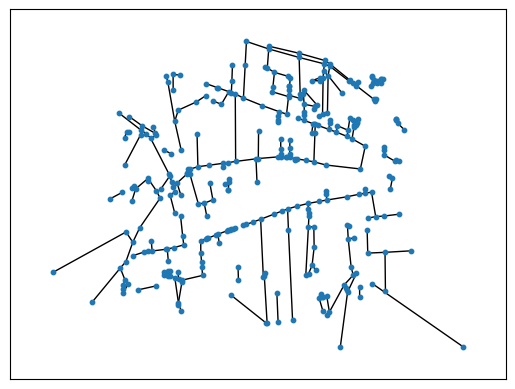

In [12]:
nx.draw_networkx(G, pos=layout, with_labels=False, node_size=10)

In [13]:
def poly_area(x,y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

In [14]:
def group_area(group, layout):
    coordinates = [layout.get(node_id) for node_id in group]
    south = min(coordinates, key=lambda x: x[1])
    west = min(coordinates, key=lambda x: x[0])
    north = max(coordinates, key=lambda x: x[1])
    east = max(coordinates, key=lambda x: x[0])
    bbox = [south, west, north, east]
    return poly_area([n[0] for n in bbox], [n[1] for n in bbox])

In [15]:
sorted_groups = sorted(nx.connected_components(G), key=lambda g: group_area(g, layout), reverse=True)
len(sorted_groups[0])

148

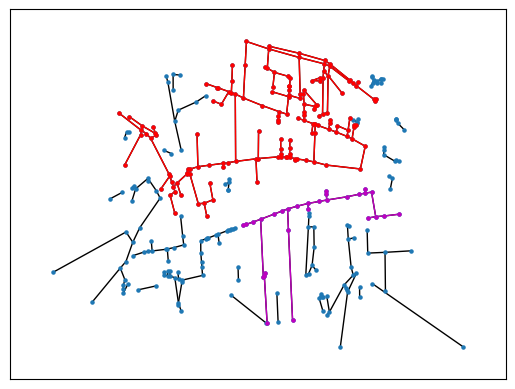

In [16]:
largest_component = G.subgraph(list(sorted_groups[0]))
second_component = G.subgraph(list(sorted_groups[1]))
nx.draw_networkx(G, pos=layout, with_labels=False, node_size=5)
nx.draw_networkx(largest_component, pos=layout, with_labels=False, node_size=5, node_color='r', edge_color='r')
nx.draw_networkx(second_component, pos=layout, with_labels=False, node_size=5, node_color='m', edge_color='m')